Notebook to querry GALEX field and visit information

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.table import unique, Table
from astropy import units as uu
from astropy.coordinates import SkyCoord
import healpy as hpy
import numpy as np
from vasca.resource_manager import ResourceManager

Get field info from astroquery

In [2]:
query_mast = False

if query_mast:
#Get TDS field info
    tt_tds = Table.read("./TDS-ApJ_766_60/tds_fields_table2.ecsv")
    dd_query = {"instrument_name":"GALEX",
                 "dataproduct_type":"image",
                 "dataRights":"PUBLIC",
                 "filters":"NUV",
                 "radius":".02 deg",
                 "target_name":tt_tds["name"]}
    # "coordinates":tt_tds["coordinates"]

    tt_obs = Observations.query_criteria(**dd_query)
    #tt_obs["obs_id","target_name"].pprint(100)
    tt_obs[0:2].show_in_notebook()

Get all-sky visit information

In [3]:
#Get data and add healpix info
rm = ResourceManager()
tt_vis = Table.read(rm.get_path("gal_visits_list", "sas_cloud"))
cosys     = "G" #"Q" for equatorial, "G" for galactic
nside     = 256
npix      = hpy.nside2npix(nside)
tt_vis["hpix"] = hpy.ang2pix(nside,tt_vis["gall"],tt_vis["galb"],lonlat=True,nest=False)

#Show exposure for different surveys
surveys =  ["AIS","MIS","DIS","NGS","GII","CAI"]
for sur in surveys:
    csel = (tt_vis['survey']==sur)
    exp_sum = (tt_vis['nexptime']*csel).sum()
    print(sur,": Visits =",csel.sum(),",exposure =",int(exp_sum),"s ,exposure per visit =",int(exp_sum/csel.sum()),"s")
    
tt_vis[0:2].show_in_notebook()

AIS : Visits = 64375 ,exposure = 6472340 s ,exposure per visit = 100 s
MIS : Visits = 11125 ,exposure = 12199096 s ,exposure per visit = 1096 s
DIS : Visits = 9775 ,exposure = 9791687 s ,exposure per visit = 1001 s
NGS : Visits = 2457 ,exposure = 2793492 s ,exposure per visit = 1136 s
GII : Visits = 7105 ,exposure = 7944605 s ,exposure per visit = 1118 s
CAI : Visits = 6028 ,exposure = 1029497 s ,exposure per visit = 170 s


idx,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,hpix
0,210.542232477159,-32.6804067553693,NGS,544.0,544.0,2391589523080347648,2391589660720627712,7804,2437,-999,visitI,7781,1,6/7/2003 5:02:29 AM,False,null,null,null,1,-999,6/7/2003 5:02:29 AM,6/7/2003 5:11:33 AM,null,null,52797.21005787037,319.74270865062874,27.871918173555255,209293
1,201.528614022379,-42.9957260941383,NGS,937.0,937.0,2391624707452436480,2391624845092716544,74460,2438,-999,visitI,8258,1,6/7/2003 6:41:02 AM,False,null,null,null,1,-999,6/7/2003 6:41:02 AM,6/7/2003 6:56:39 AM,null,null,52797.278495370374,309.64494588030084,19.423571577159674,262512


Define visit selections

In [4]:
#Different selection criteria
sel_all   = tt_vis["hpix"]>-1e6
#"AIS" # "MIS" #"DIS","NGS","GII","CAI"
sel_sur   = (tt_vis['survey'] == "MIS") + (tt_vis['survey'] == "DIS") + (tt_vis['survey'] == "GII")
sel_pid   = tt_vis['ParentImgRunID']== 2552663716076191744
sel_hp    = tt_vis["hpix"] == 8901
sel_tile  = tt_vis["tileNum"] == 5750
obs_pos   = SkyCoord(tt_vis["gall"]*uu.deg, tt_vis["galb"]*uu.deg, frame='galactic')
sel_pos   = SkyCoord(242.36789*uu.deg, 53.67333*uu.deg, frame='icrs') #'galactic'
sel_gal   = obs_pos.separation(sel_pos)<0.5*uu.deg

# Choose selection to apply and print basic info
sel       = sel_sur

tt_vis_sel    = tt_vis[sel]
print(len(tt_vis_sel),"visits in",len(unique(tt_vis_sel, keys='ParentImgRunID')), "fields found")

# Plot visit exposure distribution

28005 visits in 9796 fields found


In [5]:
#Creat field table
tt_vis_sel_grp = tt_vis_sel.group_by('ParentImgRunID')
tt_vis_sel_grp_mean = tt_vis_sel_grp["gall","galb","nexptime"].groups.aggregate(np.mean)
tt_fd = Table()
tt_fd["field_id"] = np.array(list(tt_vis_sel_grp.groups.keys["ParentImgRunID"]))
grp_idx = tt_vis_sel_grp.groups.indices
tt_fd["nr_vis"] = grp_idx[1:]-grp_idx[0:-1]
tt_fd["nexptime_mean"]= tt_vis_sel_grp_mean["nexptime"]
tt_fd["gall"]= tt_vis_sel_grp_mean["gall"]
tt_fd["galb"]= tt_vis_sel_grp_mean["galb"]

In [6]:
#Select fields
sel_fd_nexptime = tt_fd["nexptime_mean"]>700
sel_fd_nr_vis = tt_fd["nr_vis"]>2
sel_fd = sel_fd_nexptime*sel_fd_nr_vis

print("Selected fields have a total number of visits of:",tt_fd[sel_fd]["nr_vis"].sum())

Selected fields have a total number of visits of: 13534


Text(0.5, 0, 'Mean exposure time[s]')

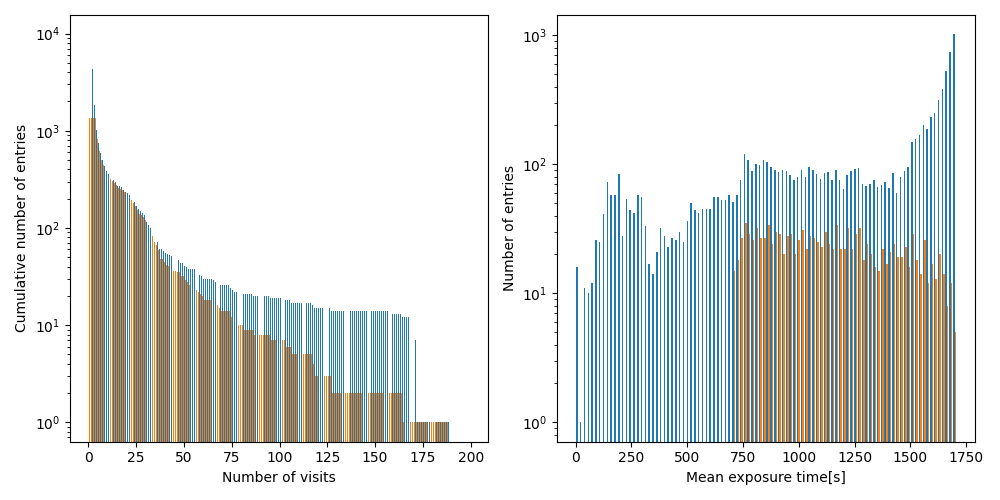

In [7]:
fig, axs = plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
hist = axs[0].hist([tt_fd["nr_vis"],tt_fd[sel_fd]["nr_vis"]], bins= range(0,200),cumulative=-1)
axs[0].set_yscale("log")
axs[0].set_ylabel("Cumulative number of entries")
axs[0].set_xlabel("Number of visits")
hist = axs[1].hist([tt_fd["nexptime_mean"],tt_fd[sel_fd]["nexptime_mean"]], bins= 100)
axs[1].set_yscale("log")
axs[1].set_ylabel("Number of entries")
axs[1].set_xlabel("Mean exposure time[s]")

Plot coverage on the sky

High resolution pixel diameter: 0.0143 deg Npix: 201326592 Nside: 4096


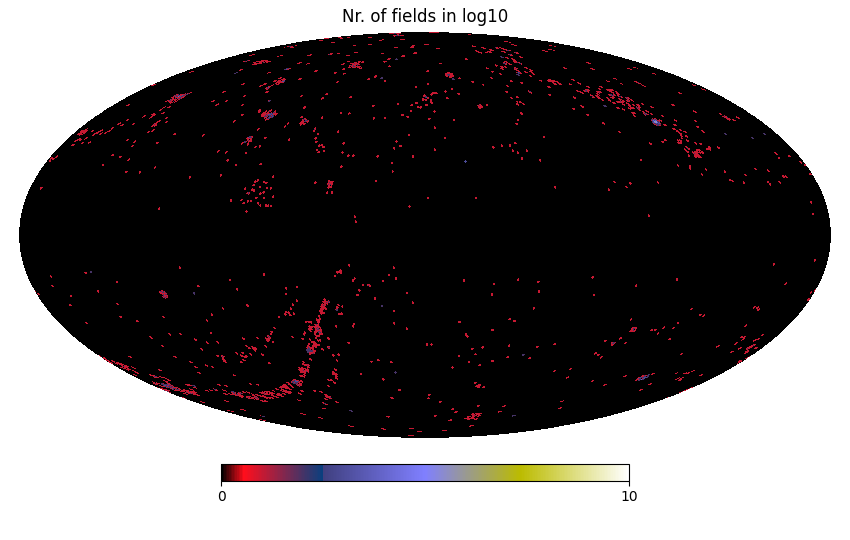

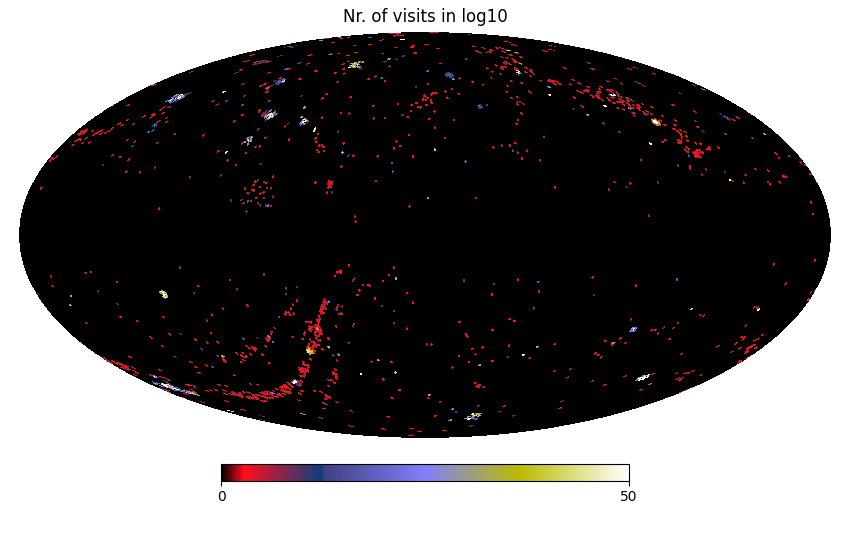

In [9]:
plot_sky = True
if plot_sky:
    #Setup high res plotting data
    nside_hres     = nside*16
    npix_hres = hpy.nside2npix(nside_hres)
    pix_diam_hres = hpy.nside2resol(nside_hres, arcmin=True) / 60 * uu.deg
    print("High resolution pixel diameter:",np.round(pix_diam_hres,4),"Npix:",npix_hres,"Nside:",nside_hres)
    tt_fd["hvec"] = hpy.ang2vec(tt_fd["gall"],tt_fd["galb"],lonlat=True)

    nr_vis_hres = np.zeros(npix_hres)  # empty map
    nr_fd_hres = np.zeros(npix_hres)  # empty map
    GALEX_FOV = 0.5  # disc radius in deg

    # fill map with coverage data
    for fd in tt_fd[sel_fd]:
        ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
        nr_fd_hres[ipix_disc] += 1  # number of fields
        nr_vis_hres[ipix_disc] += fd["nr_vis"]

    #Plot
    hpy.mollview(nr_fd_hres, title="Nr. of fields in log10",nest=False,cmap="gist_stern",min=0,max=10,xsize=4800)
    hpy.mollview(nr_vis_hres, title="Nr. of visits in log10",nest=False,cmap="gist_stern",min=0,max=50, xsize=4800)
    #hpy.graticule(color="white",dpar=45, dmer=60)

#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)